In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr

from datetime import date
import os
from scipy.io import loadmat
# load preset parameter values
from forecast_conf import (model_directory,x_location,y_location,range_pixels,target_lead_time,extra_data_lead_times,test_forecasts_per_set,test_time_1,test_time_2)
# import functions
from helper_functions import standardize_dims

## CNN for all lead times

-This notebook is a work in progress-

Here, the forecast lead time is included as a feature in the CNN model, so it can be used for any lead time

In [9]:
# set parameters, if different than in forecast_conf

# location of data
x_location=271.5
y_location=28.19

# size of image to consider, in +/- from data location, in number of pixels
range_pixels=25

# number of features (or "channels" in the CNN)
# For setting up the notebook, I've only used 2 (ensemble member current speed and lead time)
# But more should be used to get good performance
n_feat=2

# upfront define the testing forecasts, since these will be removed from the training data altogether to minimize data leakage
# I will pull out the last 10 forecasts
F_test_forecast=list(range(84,94))


In [10]:
# load measurements from mat file
# C is current speed
# T is time
C = loadmat('TH_current_ADCP.mat')['C'].squeeze()
T = loadmat('TH_current_ADCP.mat')['T'].squeeze()

In [11]:
import datetime
# convert matlab times to datetime
pdate=pd.to_datetime(T-719529,unit='d').round('s').values


In [12]:
# put current measurements into an xarray for ease of use and re-time to daily mean
measurements= xr.Dataset({"Speed": (["time"], C)},coords={"time": pdate})
# retime to 2h means
measurements=measurements.resample(time="2H").mean()


In [13]:
''''''''''
Now, get a list of directories with forecast data.

The data is structured such that each forecast is in one directory, 
and within each directory there is a netcdf file for each lead time, a week apart (usually 46 files)

'''''''''
ls=[x[0] for x in os.walk('.')]
forecast_directories=[]
for x in ls:
    # forecast folders are labelled by date, so have "20" in the name
    if x.find('20') > 0:
        forecast_directories.append(x)

In [14]:
# make a list of all forecast files across all directories
forecast_file_list=[]

for y in forecast_directories:
    temp=[x[2] for x in os.walk(y)]
    for m in temp[0]:
        if m.find('.nc') > 0:
            forecast_file_list.append(y+'/'+m)     
            
# sort the list of all files            
forecast_file_list.sort()

# count total number of forecast used
number_of_forecasts=len(forecast_directories)



In [15]:
from datetime import datetime, timedelta


# create arrays to hold X and Y values for CNN
# dimensions are:
# Dims: (forecast, lead times within within forecast, number of ensemble members, x-pixels, y-pixels, number of fields)
X_data=np.empty((number_of_forecasts,46,32,2*range_pixels,2*range_pixels,n_feat))

# Dims: (forecast, lead times within within forecast, number of ensemble members)
Y_data=np.empty((number_of_forecasts,46,32))


# parameters used for indexing
directory_index=0

current_directory=forecast_file_list[0][2:10]


# get indices for (x,y) measurement location
arr=xr.open_dataset(forecast_file_list[0])
arr=standardize_dims(arr)
lat=abs(arr.lat-y_location)
lon=abs(arr.lon-x_location)
y_location_index=np.argmin(lat.values)
x_location_index=np.argmin(lon.values)

In [16]:
# load the data in the correct format
for k in forecast_file_list:
    # check if moving to new forecast, and update current_directory if so
    if k[2:10] != current_directory:
        directory_index+=1
        current_directory=k[2:10]
        
    # calculate forecast lead time, in days
    # date of issue
    date1 = datetime.strptime(k[24:32], '%Y%m%d')
    # date of prediction
    date2 = datetime.strptime(k[33:41], '%Y%m%d')
    # lead time
    days_difference=(date2-date1).days
    

    arr=xr.open_dataset(k)
    arr=standardize_dims(arr)
    # load sea surface temperature
    t=arr.water_temp_mb.squeeze()
    # load current speed
    s=100*np.sqrt(arr.water_u_mb**2+arr.water_v_mb**2).squeeze()
    # load current direction
    ddir = np.arctan2(arr.water_u_mb, arr.water_v_mb).squeeze()
    # select (x,y) window
    t=t[:,y_location_index-range_pixels:y_location_index+range_pixels,x_location_index-range_pixels:x_location_index+range_pixels]
    s=s[:,y_location_index-range_pixels:y_location_index+range_pixels,x_location_index-range_pixels:x_location_index+range_pixels]
    ddir=ddir[:,y_location_index-range_pixels:y_location_index+range_pixels,x_location_index-range_pixels:x_location_index+range_pixels]
    # calculate ensemble means
    tm=t.mean(dim='ENSEMBLE')
    sm=s.mean(dim='ENSEMBLE')
    ddirm=ddir.mean(dim='ENSEMBLE')
    
    # get measurement at correct lead time
    val=measurements.sel(time=pd.to_datetime(date2), method="nearest").Speed.values


    for i in range(32):

        # put data into the array used for training and testing
        # here, you can choose which fields to use (speed, direction, seas surface temperature)
        # potential to add other measurement, and/or reanalyses fields such as wind, in the future
        # this should be vectorized, but there are some directories with less than 46 files
        
        # ensemble member surface current speed
        X_data[directory_index,days_difference,i,:,:,0]=s[i%s.shape[0],:,:].values
        
        # ensemble mean current spead
        #X_data[directory_index,days_difference,i,:,:,1]=sm.values         
        
        # ensemble memebr temperature
        #X_data[directory_index,days_difference,i,:,:,2]=t[i%s.shape[0],:,:].values        
        
        # month
        #X_data[directory_index,days_difference,i,:,:,3]=date2.month
        
        # lead time
        X_data[directory_index,days_difference,i,:,:,1]=days_difference
        
    # create y-values dataset    
    for i in range(32):
            # read predicted current at measurement location
            mod=s[i%s.shape[0],:,:].sel(lon=271.5,lat=28.19, method="nearest").squeeze().values
            # save error for each ensemble member
            Y_data[directory_index,days_difference,i]=val-mod
  
 
    
    

In [17]:
'''''''''
Split the data into test and train

'''''''''





# define training and testing forecasts



# Gather list for forecast on which to train and test on
F_all=list(range(94))
F_all= np.delete(F_all,F_test_forecast)

print('Forecasts for training: ',F_all)
print('Forecasts for testing: ',F_test_forecast)

Forecasts for training:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Forecasts for testing:  [84, 85, 86, 87, 88, 89, 90, 91, 92, 93]


In [42]:
# populate arrays



X_data_train=X_data[F_all,:,:,:,:,:]
Y_data_train=Y_data[F_all,:,:]

X_data_test=X_data[F_test_forecast,:,:,:,:,:]
Y_data_test=Y_data[F_test_forecast,:,:]



X_data_train=X_data_train.reshape(np.array(X_data_train.shape[:3]).prod(),2*range_pixels,2*range_pixels,n_feat)
Y_data_train=Y_data_train.reshape(np.array(Y_data_train.shape[:3]).prod(),1)

#X_data_test=X_data_test.reshape(np.array(X_data_test.shape[:2]).prod(),2*range_pixels,2*range_pixels,n_feat)
#Y_data_test=Y_data_test.reshape(np.array(Y_data_test.shape[:2]).prod(),1)
Y_data_test_flat=Y_data_test.reshape(np.array(Y_data_test.shape[:3]).prod(),1)

In [43]:
# shuffle training data


p = np.random.permutation(X_data_train.shape[0])
X_data_train=X_data_train[p,:,:,:]
Y_data_train=Y_data_train[p,:,]
I = np.argwhere(~np.isnan(Y_data_train) & ~np.isinf(Y_data_train))[:,0]
X_data_train=X_data_train[I,:,:,:]
Y_data_train=Y_data_train[I,:]



In [44]:
# build tensorflow CNN model
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=(2*range_pixels,2*range_pixels, n_feat)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(132, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))


In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        608       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [46]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [49]:
history = model.fit(X_data_train, Y_data_train, epochs=20,validation_split = 0.1,batch_size=50)
# Save the weights
model.save_weights(model_directory)

Epoch 1/10
2198/2198 [==============================] - 149s 68ms/step - loss: 1033.6401 - val_loss: 1113.4705
Epoch 2/10
2198/2198 [==============================] - 155s 71ms/step - loss: 1024.9681 - val_loss: 1090.9493
Epoch 3/10
2198/2198 [==============================] - 127s 58ms/step - loss: 1008.4167 - val_loss: 1086.5547
Epoch 4/10
2198/2198 [==============================] - 136s 62ms/step - loss: 997.3138 - val_loss: 1093.7126
Epoch 5/10
2198/2198 [==============================] - 132s 60ms/step - loss: 982.8508 - val_loss: 1075.0487
Epoch 6/10
2198/2198 [==============================] - 133s 61ms/step - loss: 972.6042 - val_loss: 1117.5264
Epoch 7/10
2198/2198 [==============================] - 146s 67ms/step - loss: 961.1475 - val_loss: 1078.4877
Epoch 8/10
2198/2198 [==============================] - 145s 66ms/step - loss: 954.0338 - val_loss: 1062.4464
Epoch 9/10
2198/2198 [==============================] - 145s 66ms/step - loss: 948.8708 - val_loss: 1098.6251
Epoch 1

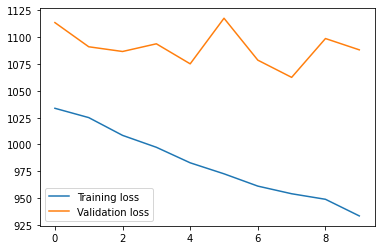

In [50]:
# plot losses
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Mean model error raw: -13.4 +/- 19.2
Mean model error calibrated: -25.5 +/- 20.2


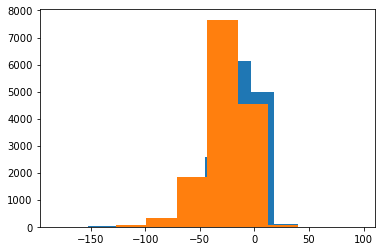

In [56]:
# test for model on unseen, un-shuffled data, after training
model.load_weights(model_directory)

plt.hist(Y_data_test_flat)
P=model.predict(X_data_test.reshape(np.array(X_data_test.shape[:3]).prod(),2*range_pixels,2*range_pixels,n_feat))
plt.hist(Y_data_test_flat-P)


print('Mean model error raw: ' + str('%.1f' % np.nanmean(Y_data_test_flat))+ ' +/- '+str( '%.1f' %np.nanstd(Y_data_test_flat)))
print('Mean model error calibrated: ' + str( '%.1f' %np.nanmean(Y_data_test_flat-P))+ ' +/- '+str( '%.1f' %np.nanstd(Y_data_test_flat-P)))


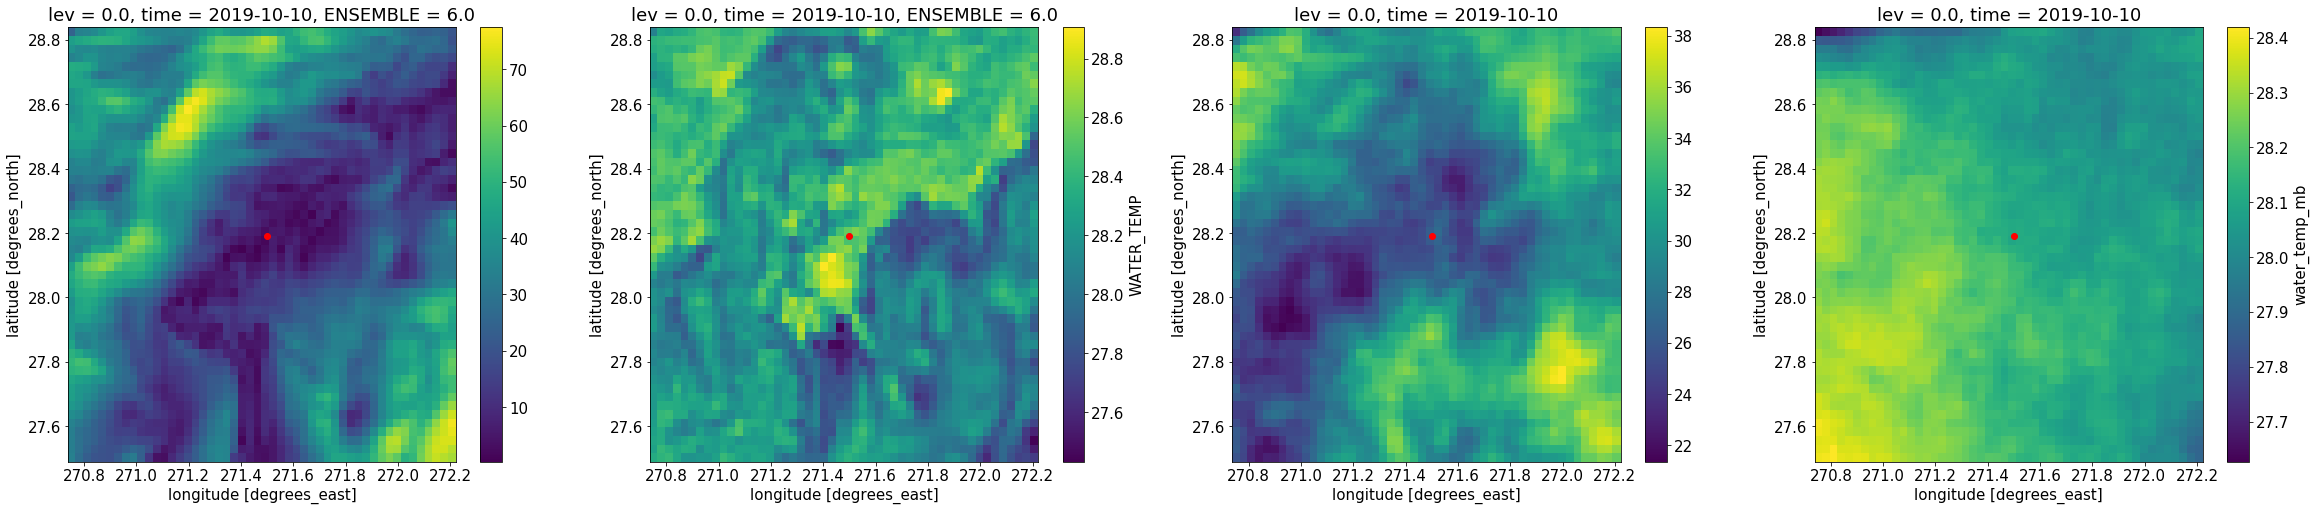

In [92]:
# plot some example images going into the CNN
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(40,8))
plt.subplot(141)
s[5,:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(142)
t[5,:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(143)
sm[:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(144)
tm[:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.savefig('./example_input.png')

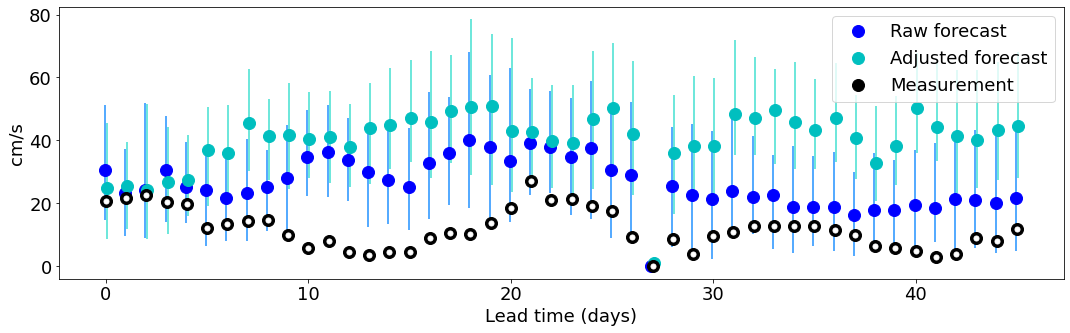

In [73]:
# finally, plot what predicted error from the CNN model would do to the unseen forecasts
# Here, we use the mean of the corrected forecast to adjust the mean of the raw forecast
# Since the CNN model is trained to bias correct individual ensemble members, it changes the spread of the forecast.
# The spread of the CNN-corrected ensemble is not calibrated, whereas the spread of the raw model is, so we
# keep the ensemble spread of the raw forecast but correct the mean

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,5))

# specify chich forecast to look at
k=4    



for i in range(46):
    p=X_data_test[k,i,:,range_pixels,range_pixels,0]
    pc=model.predict(X_data_test[k,i,:,:,:,:])
    measured_data=Y_data_test[k,i,:]+p
    plt.plot((i-0.05),np.mean(p),'bo', markersize=12, label='Raw forecast')
    
    plt.plot((i+0.05),np.mean(p+np.mean(pc)),'co', markersize=12, label='Adjusted forecast')
    p1=np.percentile(p,5)
    p2=np.percentile(p,95)
    err=np.empty((2,1))
    err[0,0]=abs(p1-np.mean(p))
    err[1,0]=p2-np.mean(p)
    plt.errorbar((i+0.05),np.mean(p+np.mean(pc)),yerr=err,ecolor='turquoise')
    plt.errorbar((i-0.05),np.mean(p),yerr=err,ecolor='dodgerblue')
    plt.plot(i,measured_data[0],'ko', markersize=12, label='Measurement')
    plt.plot(i,measured_data[0],'wo', markersize=5)
plt.xlabel('Lead time (days)')
plt.ylabel('cm/s')
plt.legend(['Raw forecast', 'Adjusted forecast', 'Measurement'])
plt.savefig('./forecast_adj_test.png')